In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from tqdm import tqdm 
import time
from torch.utils.data import random_split, Dataset, DataLoader, BatchSampler, SequentialSampler
from torchvision.models.resnet import ResNet18_Weights
import pickle
import random
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

/raid/ganesh/namitha/miniconda3/envs/submodlib-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:5" # change the available gpu number
else:
    device = "cpu"

In [4]:
data_dir = "../data"
seed = 42
gen_for = "train"

In [5]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')

/raid/ganesh/namitha/miniconda3/envs/submodlib-env/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
fullset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=None)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=None)

trainset = fullset

# validation_set_fraction = 0.1
# num_fulltrn = len(fullset)
# num_val = int(num_fulltrn * validation_set_fraction)
# num_trn = num_fulltrn - num_val
# trainset, valset = random_split(fullset, [num_trn, num_val], generator=torch.Generator().manual_seed(seed))


Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(type(testset))

<class 'torchvision.datasets.cifar.CIFAR10'>


In [8]:
if gen_for=="train":
    l = list(zip(*trainset))
elif gen_for=="val":
    l = list(zip(*valset))
else: 
    l = list(zip(*testset))
    
images = list(l[0])
labels = list(l[1])

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
model = ViTModel.from_pretrained('facebook/dino-vitb16')
model= model.to(device)

sampler = BatchSampler(SequentialSampler(range(len(images))), 20, drop_last=False)

inputs = []
for indices in tqdm(sampler):
    if images[0].mode == 'L':
        images_batch = [images[x].convert('RGB') for x in indices]
    else:
        images_batch = [images[x] for x in indices]
    inputs.append(feature_extractor(images_batch, return_tensors="pt"))


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 2500/2500 [03:18<00:00, 12.60it/s]


In [10]:
print(inputs[-1]['pixel_values'].shape)

torch.Size([20, 3, 224, 224])


In [11]:
img_features = []
for batch_inputs in tqdm(inputs):
    tmp_feat_dict = {}
    for key in batch_inputs.keys():
        tmp_feat_dict[key] = batch_inputs[key].to(device=device)
    with torch.no_grad():
        batch_outputs = model(**tmp_feat_dict)
    batch_img_features = batch_outputs.last_hidden_state[:, 0, :].cpu()
    img_features.append(batch_img_features)
    del tmp_feat_dict

img_features = torch.cat(img_features, dim=0)

100%|██████████| 2500/2500 [02:18<00:00, 18.04it/s]


In [12]:
print(len(img_features))

50000


In [13]:
print(img_features[0])

tensor([ 8.8978e-01, -6.3212e+00, -6.9181e-01, -1.4464e+00, -1.8335e+00,
         3.1475e+00, -9.9643e-01, -5.7139e+00,  1.1702e+00, -1.1717e+00,
        -1.2492e+00,  1.0339e+00,  1.2923e+00, -1.9246e+00, -1.8985e+00,
        -1.8697e+00, -1.2201e+00,  9.3051e-01,  1.6888e+00,  2.6289e+00,
         9.1540e-01, -2.9322e-01, -3.7355e+00,  8.1620e-01, -2.4800e+00,
         3.3918e+00, -1.9557e+00, -1.1021e+00,  7.6965e-01, -1.5778e+00,
        -7.1605e-01,  1.0714e+00,  5.5071e-01,  5.6272e+00, -3.2170e-01,
         6.1667e+00,  1.0122e+00, -3.0052e+00, -3.9802e-01, -3.1824e-01,
        -7.3926e-01, -7.7348e-02, -5.8888e-01,  1.7290e+00,  1.0743e+01,
        -2.3264e+00,  1.2374e+00, -1.1408e+00, -2.5777e+00,  1.2889e+00,
        -2.2574e+00, -4.1362e-01,  5.1761e+00, -3.8840e-01, -6.9574e+00,
         6.1980e-01, -1.2141e-01,  1.5531e+00, -1.4215e+00, -8.0846e-01,
         2.8767e-01,  3.5750e+00, -3.1802e+00, -1.5263e+00,  5.0163e-01,
        -3.6007e-01, -2.2853e+00, -1.0308e+01,  2.9

In [18]:
data = {}
indexes = range(len(trainset))
data["Index"] = indexes
data["Label"] = labels
data["Features"] = list(img_features.numpy())

In [19]:
print(img_features.shape)

torch.Size([50000, 768])


In [20]:
import pandas as pd
df = pd.DataFrame(data)

In [21]:
with open(f"./cifar10-dino-cls/dataframe-{gen_for}.pkl", 'wb') as file:
    pickle.dump(df, file)

## Check

In [22]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

with open(f"./cifar10-dino-cls/dataframe-{gen_for}.pkl", 'rb') as f:
    data = pickle.load(f)

In [ ]:
n_components = 5
pca = PCA(n_components=n_components)
features_matrix = np.stack(data['Features'].values)
reduced_features = pca.fit_transform(features_matrix)
data['Reduced_Features'] = list(reduced_features)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 18.208914
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.743088
[t-SNE] KL divergence after 300 iterations: 1.411754


/tmp/ipykernel_2951321/1460110198.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(dataframes))  # Get a colormap with enough colors


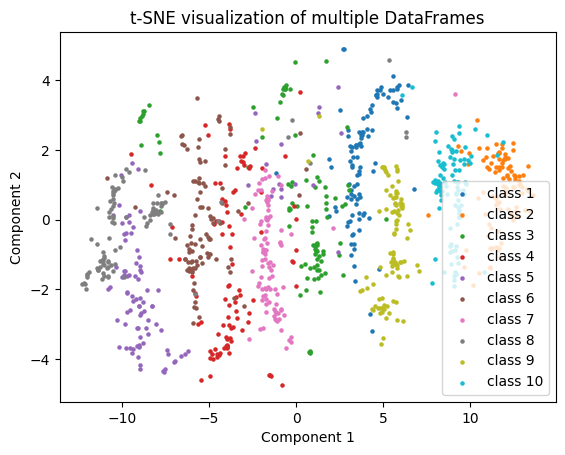

In [24]:
col = "Features"

groups = data.groupby('Label')
dataframes = [group for _, group in groups]

np.random.seed(42)
n = 100

all_samples = pd.concat([df.sample(n) for df in dataframes], ignore_index=True)
features = np.stack(all_samples[col].values)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)

colors = plt.cm.get_cmap('tab10', len(dataframes))  # Get a colormap with enough colors
fig, ax = plt.subplots()

for i, df in enumerate(dataframes):
    start_idx = i * n
    end_idx = start_idx + n
    ax.scatter(tsne_results[start_idx:end_idx, 0], tsne_results[start_idx:end_idx, 1], color=colors(i), label=f'class {i+1}', s=5)

ax.legend()
plt.title('t-SNE visualization of multiple DataFrames')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()